<a href="https://colab.research.google.com/github/Diya-Amith/Image-segmentation-/blob/main/FinalCode22071849.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **INITIAL LOADING**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.patches as patches
import seaborn as sns
from pycocotools.coco import COCO
import os
import pandas as pd
import seaborn as sns
import random
import cv2
from collections import Counter
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
# Folder paths
base_dir = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset"

# Training
train_img_dir = f"{base_dir}/train/data/"
train_labels  = f"{base_dir}/train/labels.json"
train_coco    = COCO(train_labels)

# Validation
val_img_dir = f"{base_dir}/validation/data/"
val_labels  = f"{base_dir}/validation/labels.json"
val_coco    = COCO(val_labels)

# Test
test_img_dir = f"{base_dir}/test"

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


## **EDA**

### **Load Images from Folders and Count Dataset Size**

In [ ]:
#  Load image
def get_images_from_dir(coco, folder_path):
    all_img_ids = coco.getImgIds()
    imgs = coco.loadImgs(all_img_ids)
    return [img for img in imgs if os.path.exists(f"{folder_path}/{img['file_name']}")]

train_imgs = get_images_from_dir(train_coco, train_img_dir)
val_imgs   = get_images_from_dir(val_coco, val_img_dir)
test_imgs  = os.listdir(test_img_dir)

print(f"Train images: {len(train_imgs)}")
print(f"Val images: {len(val_imgs)}")
print(f"Test images (no labels): {len(test_imgs)}")


Train images: 300
Val images: 300
Test images (no labels): 30


### **Category Name by ID**

In [ ]:
def get_name_by_id(category_id, category_list):
    for category in category_list:
        if category["id"] == category_id:
            return category["name"]
    return "Unknown"

train_category_info = train_coco.loadCats(train_coco.getCatIds())
val_category_info   = val_coco.loadCats(val_coco.getCatIds())

# Pick test IDs to check
test_ids = [1, 3, 5, 10, 20]

print("From training labels:")
for cid in test_ids:
    print(f"  ID {cid} → {get_name_by_id(cid, train_category_info)}")

print("\nFrom validation labels:")
for cid in test_ids:
    print(f"  ID {cid} → {get_name_by_id(cid, val_category_info)}")


From training labels:
  ID 1 → backpack
  ID 3 → baseball bat
  ID 5 → bear
  ID 10 → book
  ID 20 → chair

From validation labels:
  ID 1 → apple
  ID 3 → banana
  ID 5 → baseball glove
  ID 10 → book
  ID 20 → clock


### **View All Categories and Their IDs**

In [ ]:
category_ids = train_coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = train_coco.loadCats(ids=ids)
    print(cats)

number of categories:  63
[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}]
[{'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}]
[{'id': 2, 'name': 'banana', 'supercategory': 'food'}]
[{'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}]
[{'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}]
[{'id': 5, 'name': 'bear', 'supercategory': 'animal'}]
[{'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}]
[{'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}]
[{'id': 8, 'name': 'bird', 'supercategory': 'animal'}]
[{'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}]
[{'id': 10, 'name': 'book', 'supercategory': 'indoor'}]
[{'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}]
[{'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}]
[{'id': 13, 'name': 'broccoli', 'supercategory': 'food'}]
[{'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}]
[{'id': 15, 'name': 'cake', 'supercategory': 'food'}]
[{'id': 16, 'name': 'car', 'supercategory': 've

In [ ]:
filterClasses = ["cake", "car", "dog", "person"]

catIds = train_coco.getCatIds(catNms=filterClasses)
print(catIds)

[15, 16, 25, 41]


### **Show Annotations for One Sample Image**

Category Details: [{'id': 15, 'name': 'cake', 'supercategory': 'food'}]
Sample Image ID for category 15: 240
Corresponding Image File: 000000016254.jpg


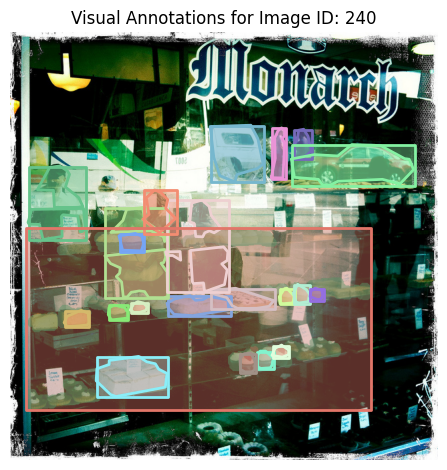

In [ ]:
selected_category_id = 15
category_details = train_coco.loadCats(ids=selected_category_id)
print("Category Details:", category_details)

image_ids = train_coco.getImgIds(catIds=[selected_category_id])
chosen_image_id = image_ids[0]
print(f"Sample Image ID for category {selected_category_id}:", chosen_image_id)

# Load annotations for the selected image
annotation_ids = train_coco.getAnnIds(imgIds=[chosen_image_id], iscrowd=None)
annotations = train_coco.loadAnns(annotation_ids)

# Load and display the corresponding image
image_info = train_coco.loadImgs(chosen_image_id)[0]
image_file = image_info['file_name']
print("Corresponding Image File:", image_file)

# Display the image with annotations
img = plt.imread(os.path.join(train_img_dir, image_file))
plt.imshow(img)
train_coco.showAnns(annotations, draw_bbox=True)
plt.axis('off')
plt.title(f'Visual Annotations for Image ID: {chosen_image_id}')
plt.tight_layout()
plt.show()


### **Category–Image Relationships**

Total Categories Found: 63
List of Category Names: ['airplane', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'kite', 'knife', 'laptop', 'motorcycle', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'skateboard', 'skis', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'tennis racket', 'tie', 'traffic light', 'train', 'truck', 'umbrella', 'vase', 'wine glass']
Sample Category ID: 0, Name: airplane, Supercategory: vehicle
Selected Category Name: banana, Corresponding ID: 2
Number of Images with 'banana': 2
Details of Selected Image: {'id': 56, 'file_name': '000000004376.jpg', 'height': 424, 'width': 640, 'license': None,

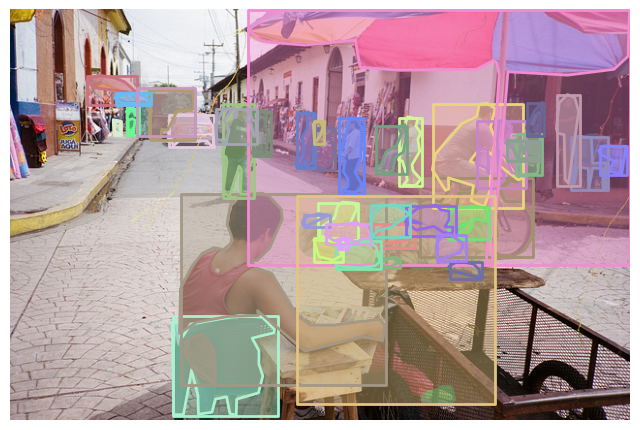

In [ ]:
def visualize_category_sample():

    all_category_ids = train_coco.getCatIds()
    print(f"Total Categories Found: {len(all_category_ids)}")

    # Load category details
    category_info = train_coco.loadCats(all_category_ids)
    category_labels = [item["name"] for item in category_info]
    print("List of Category Names:", category_labels)

    sample_category_id = all_category_ids[0]
    sample_category_data = train_coco.loadCats([sample_category_id])[0]
    print(f"Sample Category ID: {sample_category_id}, Name: {sample_category_data['name']}, Supercategory: {sample_category_data['supercategory']}")

    chosen_category_name = category_labels[2]
    chosen_category_id = train_coco.getCatIds(catNms=[chosen_category_name])[0]
    print(f"Selected Category Name: {chosen_category_name}, Corresponding ID: {chosen_category_id}")

    # Get image IDs that include this category
    related_image_ids = train_coco.getImgIds(catIds=[chosen_category_id])
    print(f"Number of Images with '{chosen_category_name}': {len(related_image_ids)}")

    # Choose image
    target_image_id = related_image_ids[0]
    image_metadata = train_coco.loadImgs([target_image_id])[0]
    print("Details of Selected Image:", image_metadata)

    # Retrieve annotations for the selected image
    annotation_list = train_coco.getAnnIds(imgIds=[target_image_id], iscrowd=None)
    loaded_annotations = train_coco.loadAnns(annotation_list)

    # Load and display the image
    image_path = os.path.join(train_img_dir, image_metadata["file_name"])
    image_data = plt.imread(image_path)

    plt.figure(figsize=(8, 6))
    plt.axis("off")
    plt.imshow(image_data)
    plt.savefig(f"{target_image_id}_original.jpg", bbox_inches="tight", pad_inches=0)

    # Overlay and save annotations
    train_coco.showAnns(loaded_annotations, draw_bbox=True)
    plt.savefig(f"{target_image_id}_annotated.jpg", bbox_inches="tight", pad_inches=0)
    plt.show()

visualize_category_sample()


### **Visualize Category Distribution – Bar Chart**

/tmp/ipython-input-11-1222353747.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(y=labels, x=image_freq, palette=custom_colors)


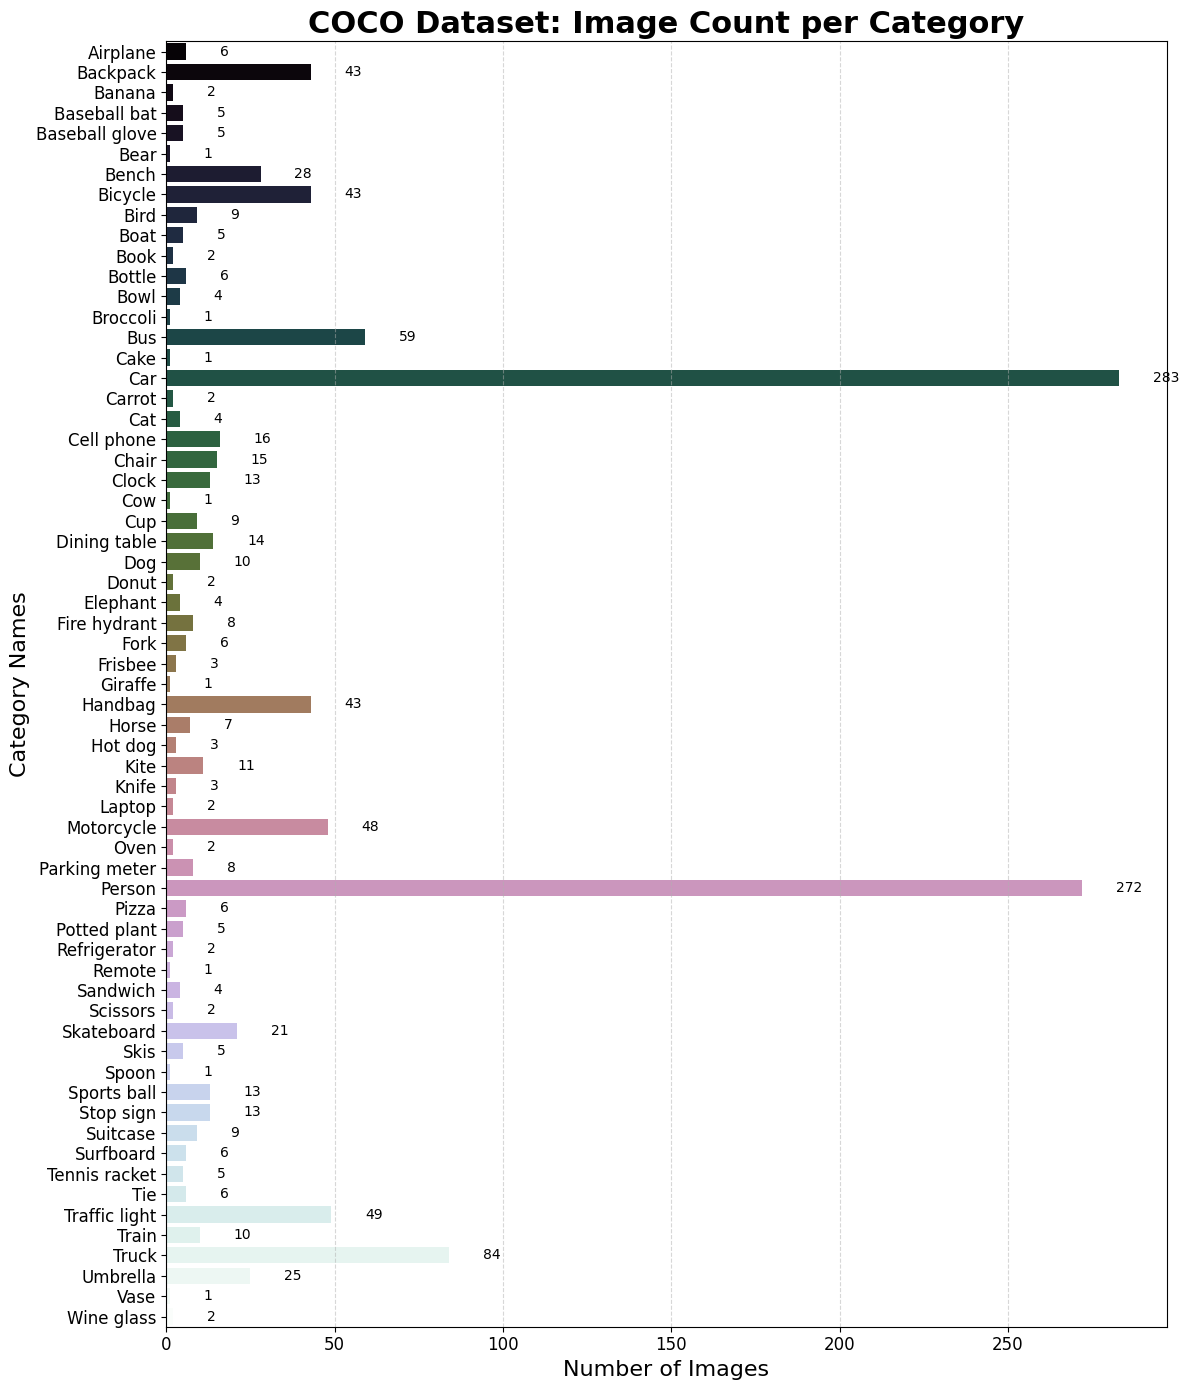

In [ ]:
category_ids = train_coco.getCatIds()
category_data = train_coco.loadCats(category_ids)

# Prepare labels and image
labels = [c['name'].capitalize() for c in category_data]
image_freq = [len(train_coco.getImgIds(catIds=[c['id']])) for c in category_data]

custom_colors = sns.color_palette("cubehelix", n_colors=len(labels))

# Plotting the bar chart
plt.figure(figsize=(12, 14))
bar_plot = sns.barplot(y=labels, x=image_freq, palette=custom_colors)


for idx, val in enumerate(image_freq):
    bar_plot.text(val + 10, idx, f"{val}", va='center', fontsize=10)

# plot
plt.title("COCO Dataset: Image Count per Category", fontsize=22, weight='bold')
plt.xlabel("Number of Images", fontsize=16)
plt.ylabel("Category Names", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("category_distribution_coco.png", dpi=300)
plt.show()


### **Number of images containing each target class**

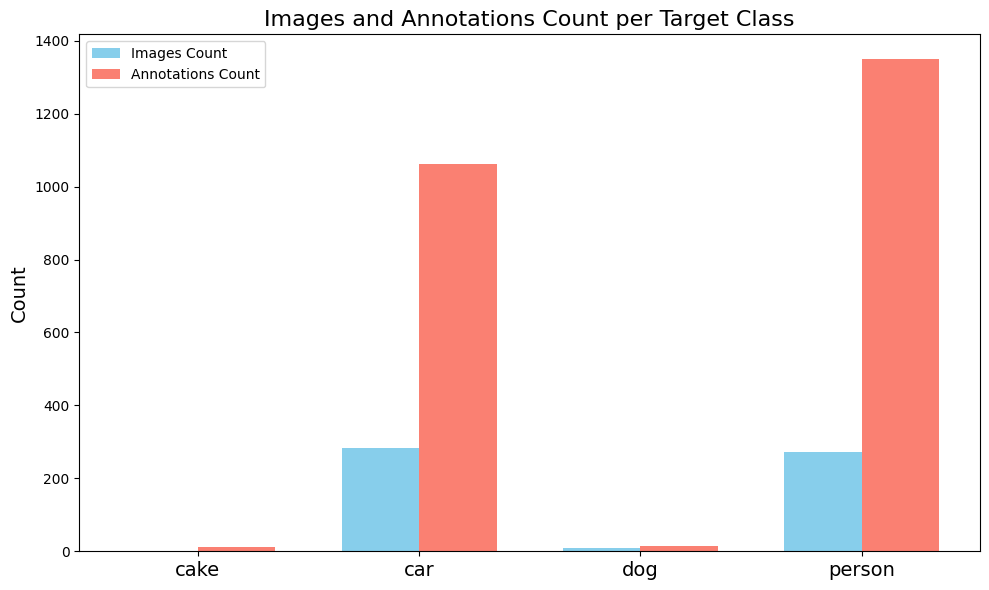

/tmp/ipython-input-12-2307056045.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(areas, label=filterClasses[i], shade=True)
/tmp/ipython-input-12-2307056045.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(areas, label=filterClasses[i], shade=True)
/tmp/ipython-input-12-2307056045.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(areas, label=filterClasses[i], shade=True)
/tmp/ipython-input-12-2307056045.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(areas, label=filterClasses[i], 

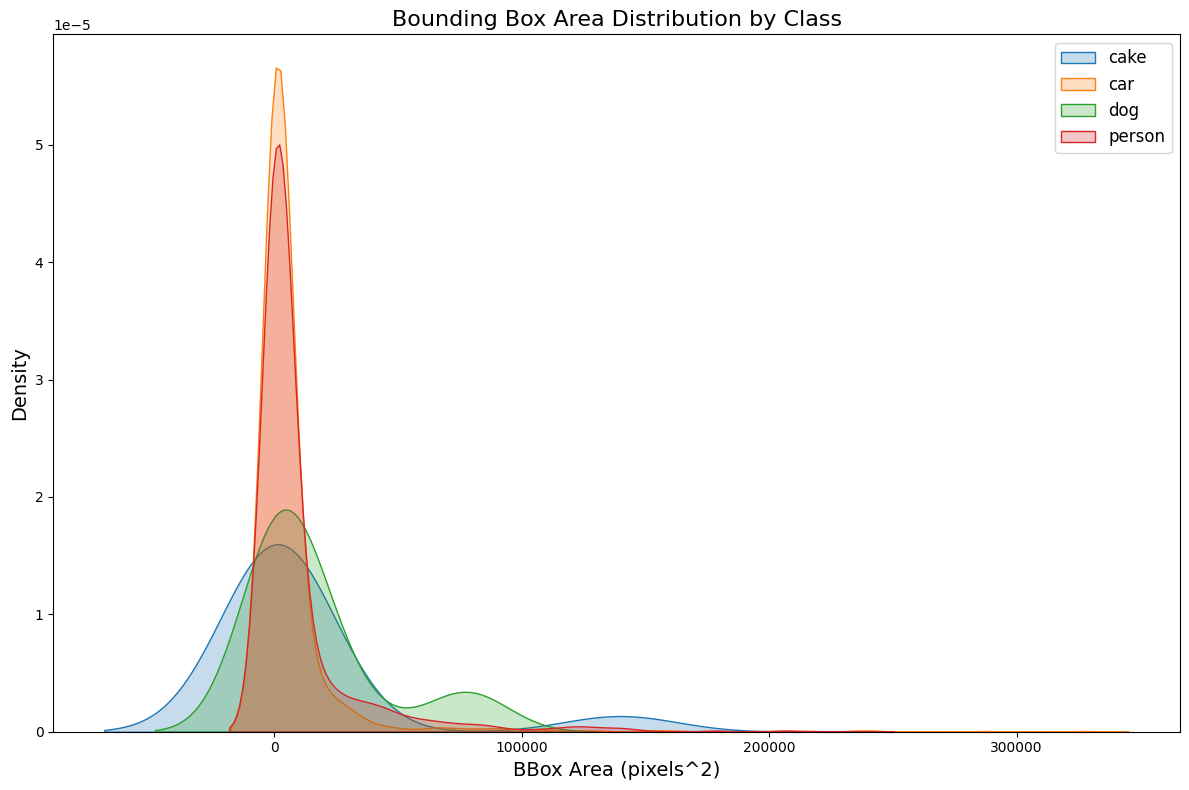

In [ ]:
# Bar plot f
target_cat_ids = train_coco.getCatIds(catNms=filterClasses)
image_counts = []
annotation_counts = []

for cat_id in target_cat_ids:
    img_ids = train_coco.getImgIds(catIds=[cat_id])
    image_counts.append(len(img_ids))

    ann_ids = train_coco.getAnnIds(catIds=[cat_id])
    annotation_counts.append(len(ann_ids))

plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = np.arange(len(filterClasses))

plt.bar(indices, image_counts, bar_width, label='Images Count', color='skyblue')
plt.bar(indices + bar_width, annotation_counts, bar_width, label='Annotations Count', color='salmon')

plt.xticks(indices + bar_width / 2, filterClasses, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Images and Annotations Count per Target Class', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

# Bounding box area
plt.figure(figsize=(12, 8))
for i, cat_id in enumerate(target_cat_ids):
    ann_ids = train_coco.getAnnIds(catIds=[cat_id])
    anns = train_coco.loadAnns(ann_ids)

    areas = [ann['bbox'][2] * ann['bbox'][3] for ann in anns]

    sns.kdeplot(areas, label=filterClasses[i], shade=True)

plt.title('Bounding Box Area Distribution by Class', fontsize=16)
plt.xlabel('BBox Area (pixels^2)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### **Correlation matrix of co-occurrence between classes in images**

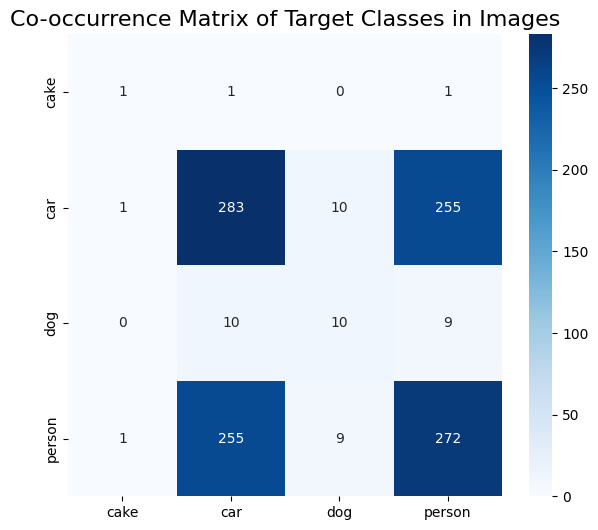

In [ ]:
# Get image IDs containing each target class
img_ids_per_class = [set(train_coco.getImgIds(catIds=[cat_id])) for cat_id in target_cat_ids]

co_occurrence = np.zeros((len(filterClasses), len(filterClasses)), dtype=int)

for i in range(len(filterClasses)):
    for j in range(len(filterClasses)):
        co_occurrence[i, j] = len(img_ids_per_class[i].intersection(img_ids_per_class[j]))

df_co = pd.DataFrame(co_occurrence, index=filterClasses, columns=filterClasses)

plt.figure(figsize=(7,6))
sns.heatmap(df_co, annot=True, fmt='d', cmap='Blues')
plt.title("Co-occurrence Matrix of Target Classes in Images", fontsize=16)
plt.show()


In [ ]:
target_classes = ["cake", "car", "dog", "person"]
train_target_class_ids = train_coco.getCatIds(catNms=target_classes)

val_target_class_ids = val_coco.getCatIds(catNms=target_classes)

print("Target classes and their IDs:")
for cls in target_classes:
    train_id = train_coco.getCatIds(catNms=[cls])[0]
    val_id = val_coco.getCatIds(catNms=[cls])[0]
    print(f"'{cls}': train ID = {train_id}, val ID = {val_id}")

Target classes and their IDs:
'cake': train ID = 15, val ID = 14
'car': train ID = 16, val ID = 15
'dog': train ID = 25, val ID = 24
'person': train ID = 41, val ID = 41


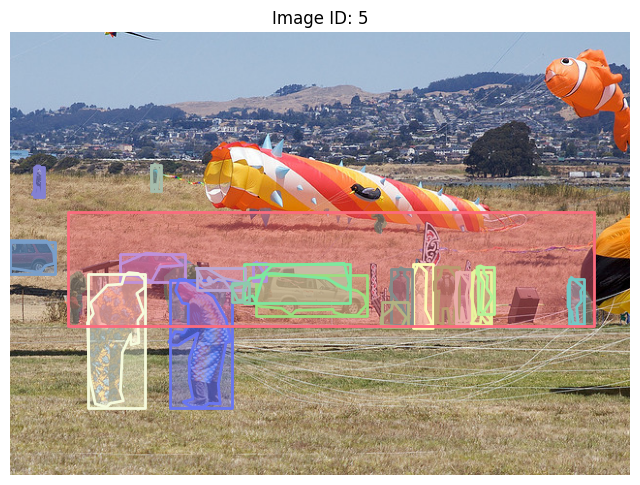

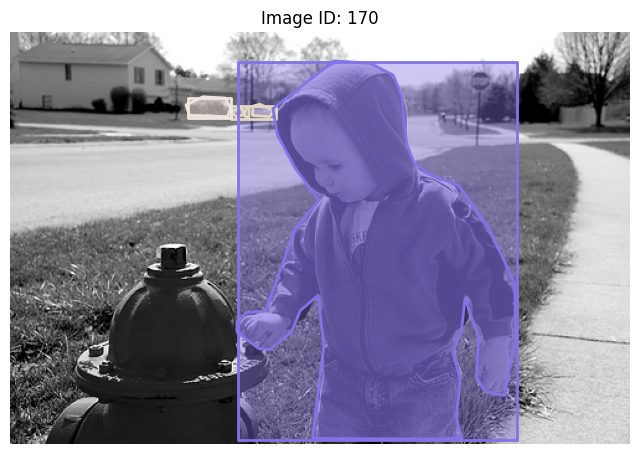

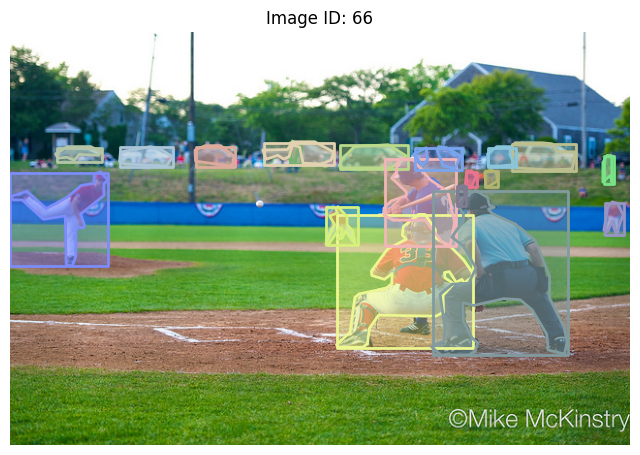

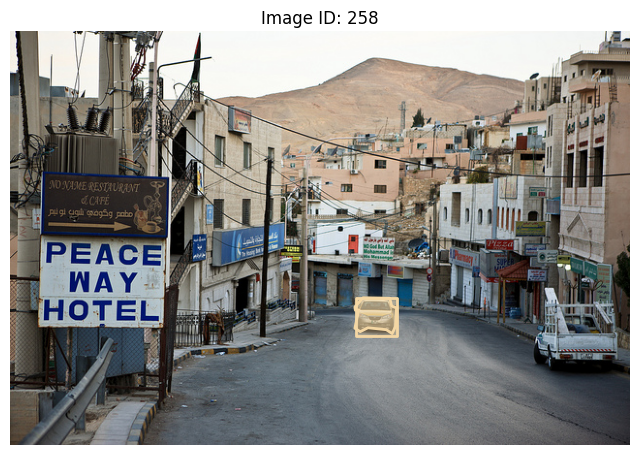

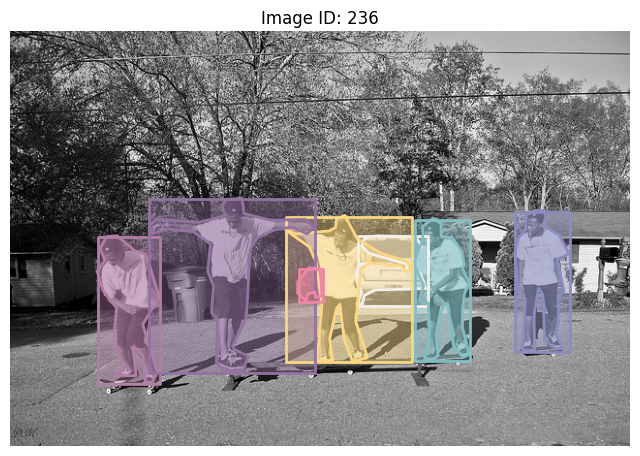

In [ ]:
# Select a few random image IDs
sample_img_ids = random.sample(balanced_train_img_ids, k=5)

# Define a function
def show_image_with_annotations(coco, image_dir, image_id, target_cat_ids):
    img_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_id, catIds=target_cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Load the image
    img_path = os.path.join(image_dir, img_info['file_name'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    coco.showAnns(anns, draw_bbox=True)
    plt.title(f"Image ID: {image_id}")
    plt.axis('off')
    plt.show()

# Loop over sample images
for img_id in sample_img_ids:
    show_image_with_annotations(train_coco, train_img_dir, img_id, train_target_class_ids)


In [ ]:
# Load all annotations from training
annotations = train_coco.loadAnns(train_coco.getAnnIds())

num_segmentations = sum(1 for ann in annotations if "segmentation" in ann and ann["segmentation"])
print(f"Number of annotations with segmentation masks: {num_segmentations} out of {len(annotations)} total annotations.")

Number of annotations with segmentation masks: 3870 out of 3870 total annotations.


In [ ]:
def show_images_for_categories(category_names):
    cat_ids = train_coco.getCatIds(catNms=category_names)
    img_ids = train_coco.getImgIds(catIds=cat_ids)
    print(f"Filtering for categories: {category_names}")
    print(f"Number of images found: {len(img_ids)}")
    print(f"Image IDs: {img_ids}\n")

show_images_for_categories(["cat"])
show_images_for_categories(["dog", "person"])
show_images_for_categories(["cake"])

Filtering for categories: ['cat']
Number of images found: 4
Image IDs: [299, 132, 268, 294]

Filtering for categories: ['dog', 'person']
Number of images found: 9
Image IDs: [32, 225, 71, 169, 111, 21, 215, 121, 159]

Filtering for categories: ['cake']
Number of images found: 1
Image IDs: [240]



In [ ]:
def count_class_occurrences(coco, cat_ids):
    ann_ids = coco.getAnnIds(catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)
    counter = Counter()
    for ann in anns:
        counter[ann["category_id"]] += 1
    return counter

print("Train class distribution:")
print(count_class_occurrences(train_coco, train_target_class_ids))

Train class distribution:
Counter({41: 1350, 16: 1061, 25: 14, 15: 13})


## **Dataset Class / Dataloader**

In [ ]:
class CustomCocoSegmentation(Dataset):
    def __init__(self, coco, image_dir, class_id_map, transform=None):
        self.coco = coco
        self.image_dir = image_dir
        self.class_id_map = class_id_map
        self.transform = transform

        valid_img_ids = set()
        for cat_id in class_id_map.keys():
            valid_img_ids.update(self.coco.getImgIds(catIds=cat_id))
        self.img_ids = list(valid_img_ids)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        image = Image.open(img_path).convert('RGB')

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=list(self.class_id_map.keys()), iscrowd=False)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        for ann in anns:
            cat_id = ann['category_id']
            class_idx = self.class_id_map[cat_id]
            mask_ = self.coco.annToMask(ann)
            mask = np.where(mask_ == 1, class_idx, mask)

        if self.transform:
            image = self.transform(image)

        mask = Image.fromarray(mask).resize((256, 256), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [ ]:
category_names = ['cake', 'car', 'dog', 'person']

coco_cat_to_class_idx = {}
for idx, name in enumerate(category_names, start=1):
    cat_ids = train_coco.getCatIds(catNms=[name])
    if cat_ids:
        coco_cat_to_class_idx[cat_ids[0]] = idx

print("COCO Category to Class Index Map:", coco_cat_to_class_idx)

COCO Category to Class Index Map: {15: 1, 16: 2, 25: 3, 41: 4}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = CustomCocoSegmentation(
    coco=train_coco,
    image_dir=train_img_dir,
    class_id_map=coco_cat_to_class_idx,
    transform=transform
)

val_dataset = CustomCocoSegmentation(
    coco=val_coco,
    image_dir=val_img_dir,
    class_id_map=coco_cat_to_class_idx,
    transform=transform
)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [ ]:
def compute_class_weights(dataset, num_classes):
    pixel_counts = torch.zeros(num_classes)

    for _, mask in dataset:
        for cls in range(num_classes):
            pixel_counts[cls] += torch.sum(mask == cls)

    pixel_counts[pixel_counts == 0] = 1
    weights = 1.0 / pixel_counts
    return weights / weights.sum()

num_classes = len(coco_cat_to_class_idx) + 1
class_weights = compute_class_weights(train_dataset, num_classes)


## **SegNet - Model Architecture**

In [ ]:
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()

        vgg16 = models.vgg16(pretrained=True)
        features = list(vgg16.features.children())
        self.encoder = nn.Sequential(*features)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


### **Training**

In [ ]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")


Epoch [1/30] - Training Loss: 0.1659
Epoch [2/30] - Training Loss: 0.1521
Epoch [3/30] - Training Loss: 0.1414
Epoch [4/30] - Training Loss: 0.1302
Epoch [5/30] - Training Loss: 0.1186
Epoch [6/30] - Training Loss: 0.1154
Epoch [7/30] - Training Loss: 0.1063
Epoch [8/30] - Training Loss: 0.1040
Epoch [9/30] - Training Loss: 0.1007
Epoch [10/30] - Training Loss: 0.0961
Epoch [11/30] - Training Loss: 0.0955
Epoch [12/30] - Training Loss: 0.0936
Epoch [13/30] - Training Loss: 0.0872
Epoch [14/30] - Training Loss: 0.0888
Epoch [15/30] - Training Loss: 0.0824
Epoch [16/30] - Training Loss: 0.0758
Epoch [17/30] - Training Loss: 0.0756
Epoch [18/30] - Training Loss: 0.0731
Epoch [19/30] - Training Loss: 0.0706
Epoch [20/30] - Training Loss: 0.0755
Epoch [21/30] - Training Loss: 0.0693
Epoch [22/30] - Training Loss: 0.0646
Epoch [23/30] - Training Loss: 0.0623
Epoch [24/30] - Training Loss: 0.0638
Epoch [25/30] - Training Loss: 0.0734
Epoch [26/30] - Training Loss: 0.0744
Epoch [27/30] - Train

In [ ]:
torch.save(model.state_dict(), "segnet_coco_subset.pth")

### **Training Curve Visualization**

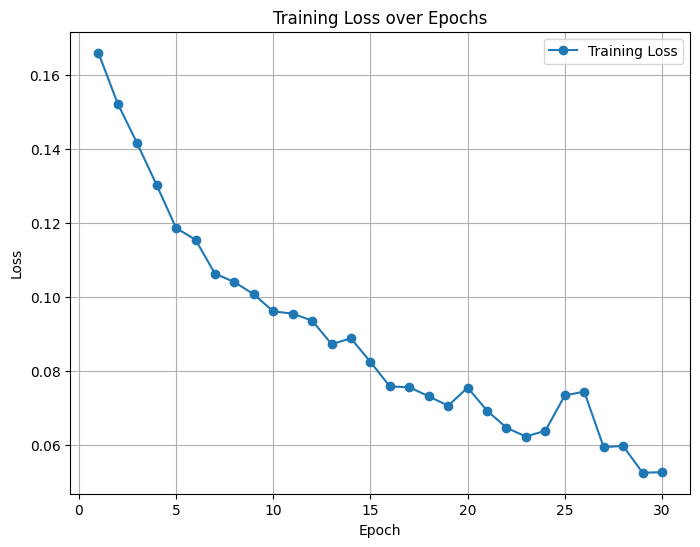

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## **Evaluation Metrics**

In [ ]:
def compute_metrics(preds, labels, num_classes):

    preds = preds.view(-1)
    labels = labels.view(-1)

    # Pixel accuracy
    correct = (preds == labels).sum().item()
    total = labels.numel()
    pixel_acc = correct / total

    # Compute IoU for each class
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    ious = torch.tensor(ious)
    mean_iou = torch.nanmean(ious).item()

    return pixel_acc, mean_iou


In [ ]:
model.eval()
all_pixel_acc = []
all_mean_iou = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        pixel_acc, mean_iou = compute_metrics(preds, masks, num_classes)
        all_pixel_acc.append(pixel_acc)


avg_pixel_acc = sum(all_pixel_acc) / len(all_pixel_acc)
print(f"Validation Pixel Accuracy: {avg_pixel_acc:.4f}")

Validation Pixel Accuracy: 0.8888


## **Validation Results Visualization**

In [ ]:
def predict_segmentation(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return pred


In [ ]:
def visualize_prediction(image_tensor, pred_mask, true_mask=None, class_labels=None):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3 if true_mask is not None else 2, 1)
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3 if true_mask is not None else 2, 2)
    plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=len(class_labels)-1 if class_labels else None)
    plt.title("Predicted Mask")
    plt.axis('off')

    if true_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask.cpu().numpy(), cmap='jet', vmin=0, vmax=len(class_labels)-1 if class_labels else None)
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


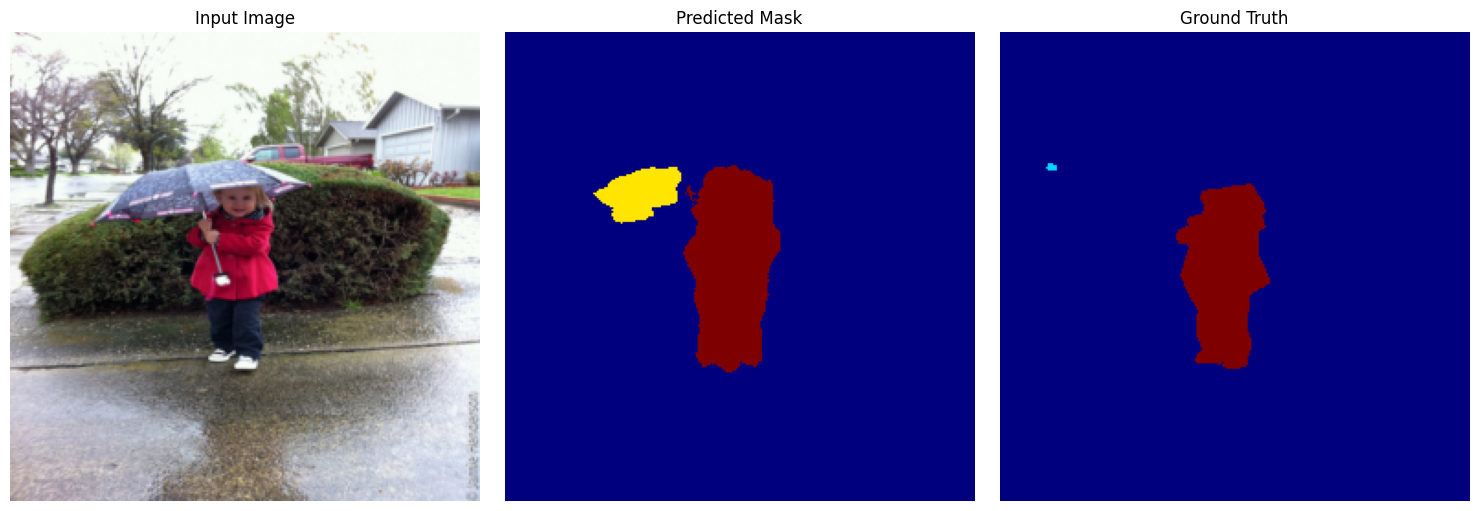

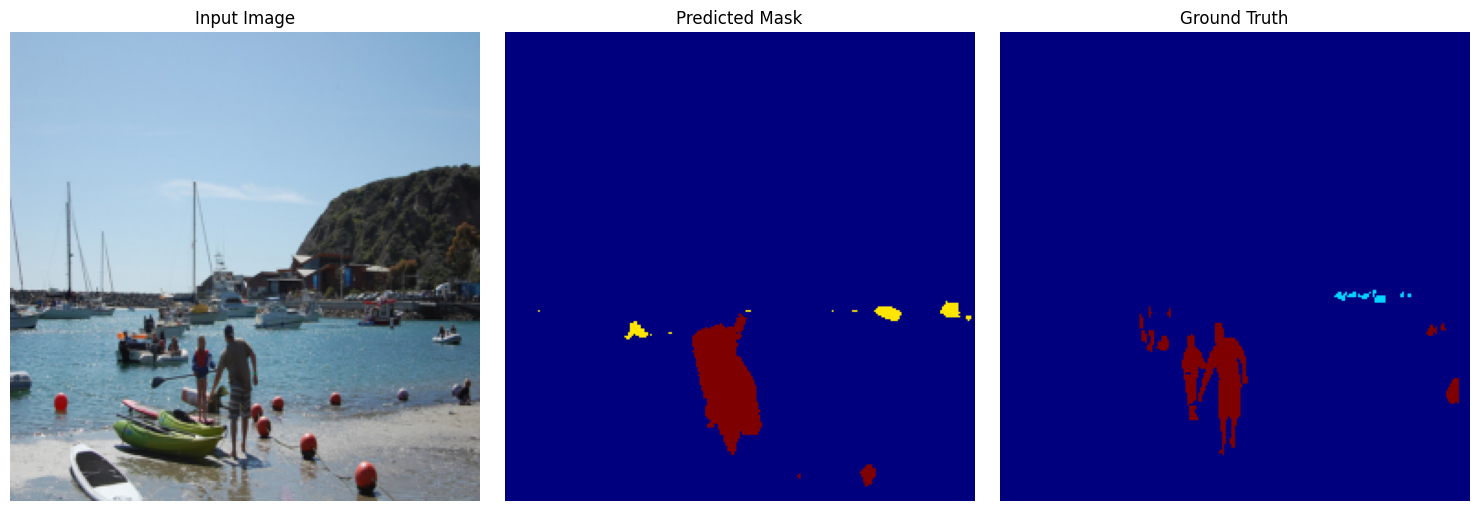

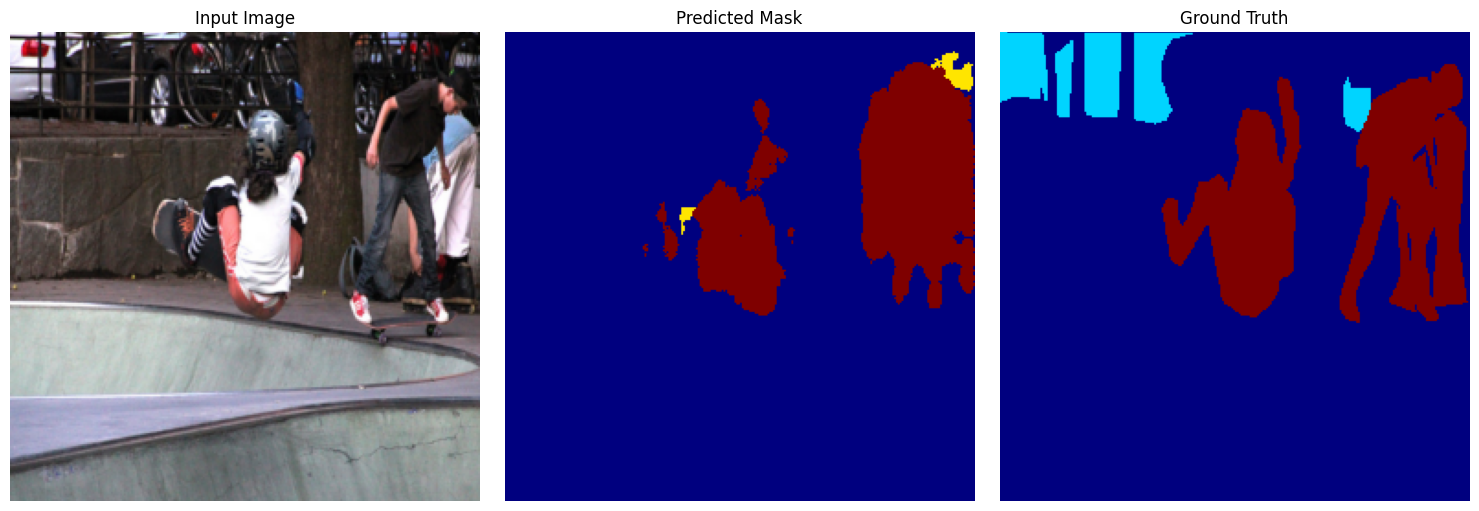

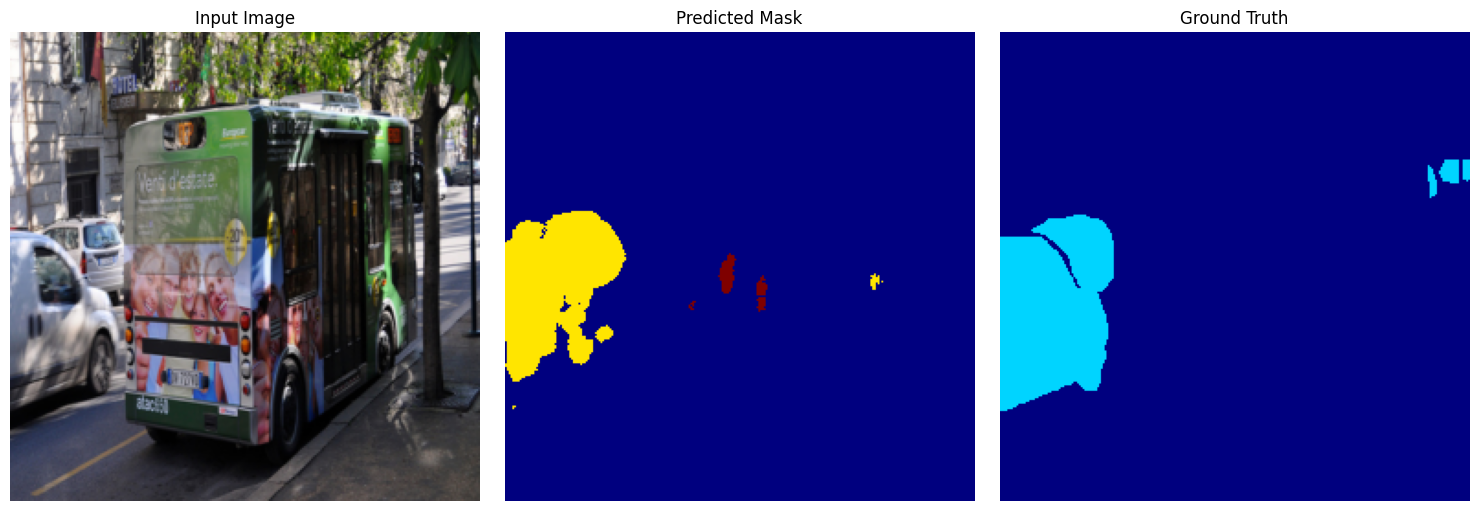

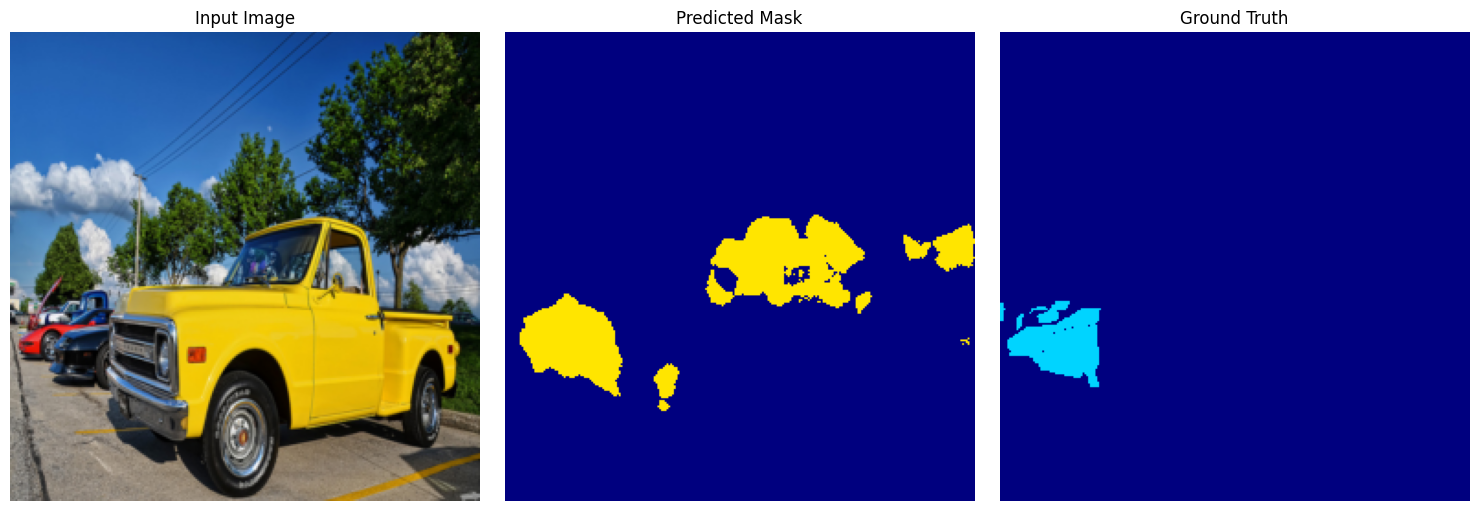

In [ ]:
num_samples = 5
indices = list(range(len(val_dataset)))
random.shuffle(indices)

for i in indices[:num_samples]:
    image_tensor, true_mask = val_dataset[i]
    pred_mask = predict_segmentation(model, image_tensor, device)
    visualize_prediction(image_tensor, pred_mask, true_mask=true_mask, class_labels=category_names)

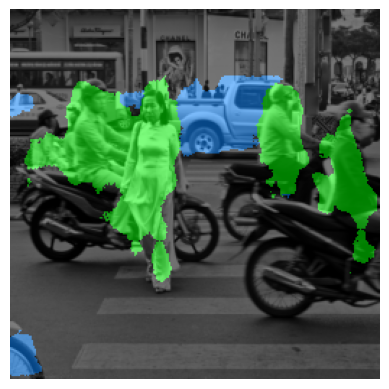

In [ ]:
def simple_overlay(image_tensor, mask, class_colors, alpha=0.5):

    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    overlay = image.copy()

    for class_idx, color in enumerate(class_colors):
        overlay[mask == class_idx] = (1 - alpha) * overlay[mask == class_idx] + alpha * np.array(color)

    plt.imshow(overlay)
    plt.axis('off')
    plt.show()



class_colors = [
    (0, 0, 0),
    (1, 0.5, 0),
    (0, 0.5, 1),
    (0.5, 0, 0.5),
    (0, 1, 0)
]

import random


random_idx = random.randint(0, len(val_dataset) - 1)

image_tensor, true_mask = val_dataset[random_idx]
pred_mask = predict_segmentation(model, image_tensor, device)

simple_overlay(image_tensor, pred_mask, class_colors, alpha=0.5)


## **Test Dataset Prediction**

Prediction for: 000000001751.jpg


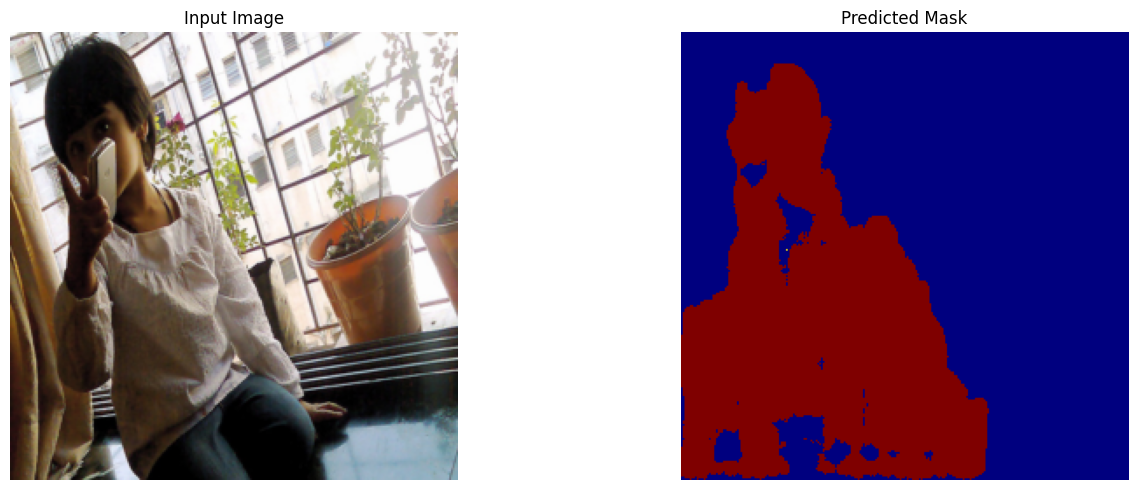

Prediction for: 000000001583.jpg


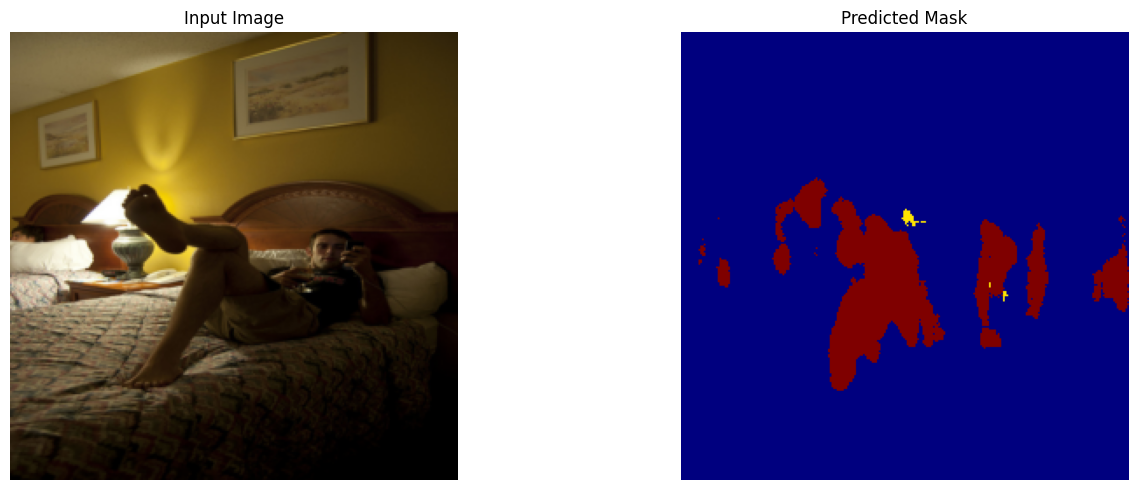

Prediction for: 000000001492.jpg


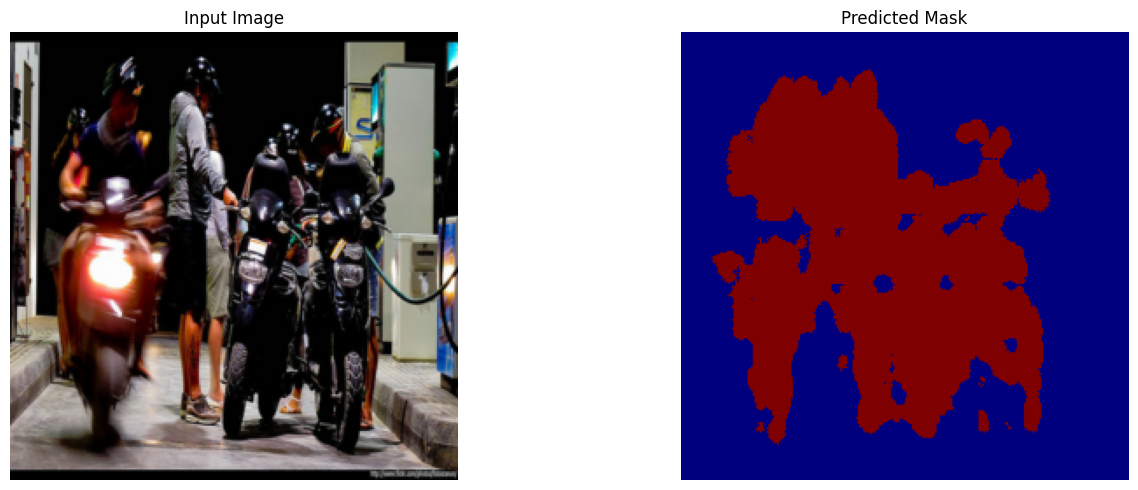

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted([
            os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
            if fname.lower().endswith((".jpg", ".png"))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

# Define test transform
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_dataset = TestDataset(test_img_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Visualize predictions
for i, (image_tensor, path) in enumerate(test_loader):
    if i >= 3:
        break
    image_tensor = image_tensor.squeeze(0)
    pred_mask = predict_segmentation(model, image_tensor, device)
    print(f"Prediction for: {os.path.basename(path[0])}")
    visualize_prediction(image_tensor, pred_mask, class_labels=category_names)


Overlay prediction for: 000000001650.jpg


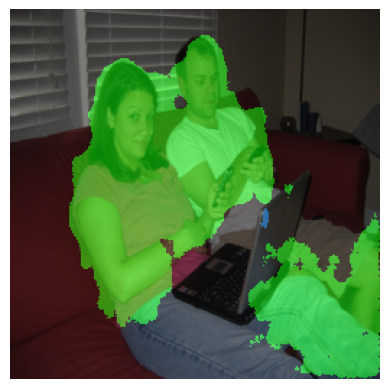

Overlay prediction for: 000000001439.jpg


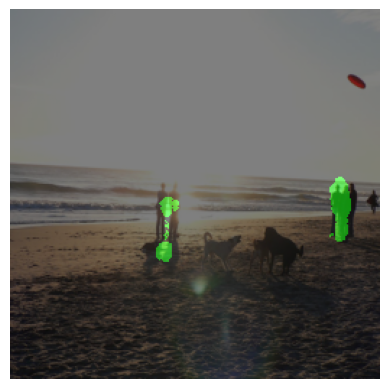

Overlay prediction for: 000000001418.jpg


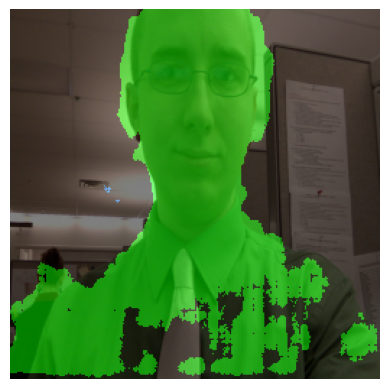

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for i, (image_tensor, path) in enumerate(test_loader):
    if i >= 3:
        break
    image_tensor = image_tensor.squeeze(0)
    pred_mask = predict_segmentation(model, image_tensor, device)

    print(f"Overlay prediction for: {os.path.basename(path[0])}")
    simple_overlay(image_tensor, pred_mask, class_colors, alpha=0.5)